In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import cv2
import imageio
import matplotlib.image as mpimg
from skimage import io
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import RMSprop,SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from statistics import mode
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-05-18 10:01:36.601560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 10:01:36.601667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 10:01:36.748315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def prepare_dataset(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224,224), cv2.INTER_AREA)
            img=img/255.0
            img_rgb = gray2RGB(img)
            if i < 100000:
                
                x_data.append(img_rgb)
                dataX.append(img_rgb)
                y_data.append(label)
                dataY.append(label)
            else: 
                break
            
            i = i + 1
    
    return  np.array(dataX),np.array(dataY)


def prepare_dataset_2(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224,224), cv2.INTER_AREA)
            img=img/255.0
            img_rgb = gray2RGB(img)
            if i < 1000: 
                x_data.append(img_rgb)
                dataX.append(img_rgb)
                y_data.append(label)
                dataY.append(label)
            else:
                break
            
            i = i + 1

    return  np.array(dataX),np.array(dataY)



def gray2RGB(array2d):
    array3d = np.tile(array2d[:,:,np.newaxis],3)
    return array3d

def all_img_rgb_converter(arrays2d):

    len, width, height = arrays2d.shape
    arrays3d = []

    for i in range(len):
        array3d = gray2RGB(arrays2d[i,:,:])
        arrays3d.append(array3d)

    arrays3d = np.array(arrays3d)
    return arrays3d

In [3]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [4]:
def accuracy_lr_loss_plot(history):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(231)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(232)
    plt.plot(history.history['learning_rate'], 'go--', label="Learning Rate")
    plt.title("Learning Rate")
    plt.xlabel("Number of epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    
    plt.subplot(233)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()


In [5]:
x_data = []
y_data = []

In [6]:
Mild_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented"
Moderate_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented"
Non_Demented_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented"
Very_mild_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented"

In [7]:
Mild_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented"
Moderate_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented"
Non_Demented_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented"
Very_mild_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented"

In [8]:
X_Mild_Dementia_test, Y_Mild_Dementia_test =  prepare_dataset(Mild_Dementia_test,0)
X_Moderate_Dementia_test, Y_Moderate_Dementia_test =  prepare_dataset(Moderate_Dementia_test,0)
X_Non_Demented_test, Y_Non_Demented_test = prepare_dataset_2(Non_Demented_test,1)
X_Very_mild_Dementia_test, Y_Very_mild_Dementia_test = prepare_dataset(Very_mild_Dementia_test,0)

In [9]:
X_Mild_Dementia_train, Y_Mild_Dementia_train =  prepare_dataset(Mild_Dementia_train,0)
X_Moderate_Dementia_train, Y_Moderate_Dementia_train =  prepare_dataset(Moderate_Dementia_train,0)
X_Non_Demented_train, Y_Non_Demented_train = prepare_dataset_2(Non_Demented_train,1)
X_Very_mild_Dementia_train, Y_Very_mild_Dementia_train = prepare_dataset(Very_mild_Dementia_train,0)

In [10]:
c_0 = 0
c_1 = 0
    
for i in y_data:
    if i == 0:
        c_0 += 1 
    elif i == 1:
        c_1 += 1
    else:
        print("asfaa")

In [11]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16

In [12]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 5)

In [13]:
VALIDATION_ACCURACY_VGG16 = []
VALIDAITON_LOSS_VGG16 = []

In [14]:
deneme_model=VGG16(input_shape = (224, 224, 3), 
                              include_top = False, 
                              weights = 'imagenet')

for layer in deneme_model.layers:
        layer.trainable = False
    

for layer in deneme_model.layers[12:]:
        layer.trainable = True



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
for i, layer in enumerate(deneme_model.layers):
    print(i,'\t',layer.trainable,'\t  :',layer.name)

0 	 False 	  : input_layer
1 	 False 	  : block1_conv1
2 	 False 	  : block1_conv2
3 	 False 	  : block1_pool
4 	 False 	  : block2_conv1
5 	 False 	  : block2_conv2
6 	 False 	  : block2_pool
7 	 False 	  : block3_conv1
8 	 False 	  : block3_conv2
9 	 False 	  : block3_conv3
10 	 False 	  : block3_pool
11 	 False 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : block4_pool
15 	 True 	  : block5_conv1
16 	 True 	  : block5_conv2
17 	 True 	  : block5_conv3
18 	 True 	  : block5_pool


fold-1 data verileri atlandı
Epoch 1/50


2024-05-18 10:02:39.672501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-18 10:02:39.672559: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-18 10:02:39.672569: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-18 10:02:39.672576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-18 10:02:39.672584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-18 10:02:39.672592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-18 10:02:39.672600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-18 10:02:39.672607: E external/local_xla/xla/se

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5869 - loss: 0.9214

W0000 00:00:1716026599.478897     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-18 10:03:21.812828: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.39009, expected 3.53025
2024-05-18 10:03:21.812881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.40727, expected 4.54742
2024-05-18 10:03:21.812891: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.56026, expected 4.70042
2024-05-18 10:03:21.812898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.58812, expected 4.72827
2024-05-18 10:03:21.812906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.9643, expected 4.10445
2024-05-18 10:03:21.812914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.19898, expected 4.33914
2024-05-18 10:03:21.812921: E external/loc


Epoch 1: val_accuracy improved from -inf to 0.58471, saving model to /kaggle/working/VGG16_model_2.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 60s 202ms/step - accuracy: 0.5872 - loss: 0.9199 - val_accuracy: 0.5847 - val_loss: 8.7862 - learning_rate: 0.0100
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7032 - loss: 0.5816
Epoch 2: val_accuracy improved from 0.58471 to 0.67355, saving model to /kaggle/working/VGG16_model_2.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.7033 - loss: 0.5815 - val_accuracy: 0.6736 - val_loss: 13.8774 - learning_rate: 0.0100
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7767 - loss: 0.5012
Epoch 3: val_accuracy did not improve from 0.67355
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.7766 - loss: 0.5013 - val_accuracy: 0.5062 - val_loss: 2.8222 - learning_rate: 0.0100
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7886 - loss: 0.4717
Epoch 4: val_accuracy did not improve 

W0000 00:00:1716027352.704138     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


<Figure size 640x480 with 0 Axes>

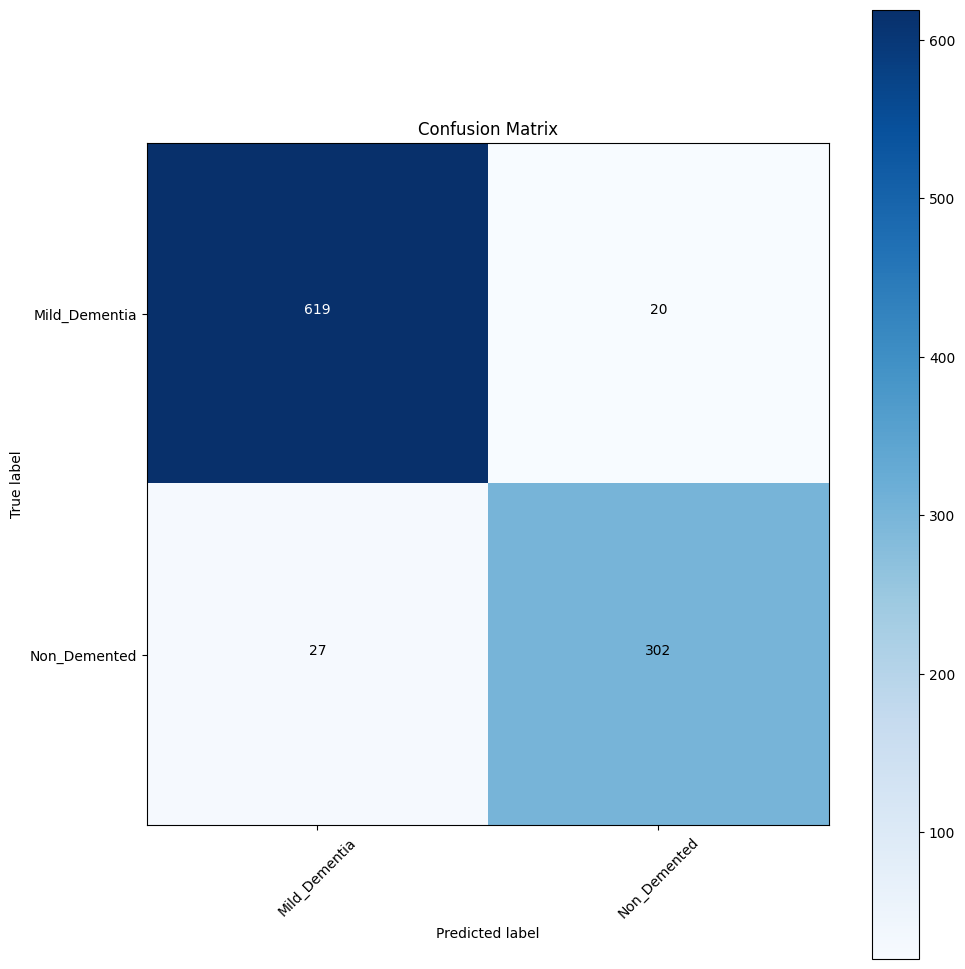

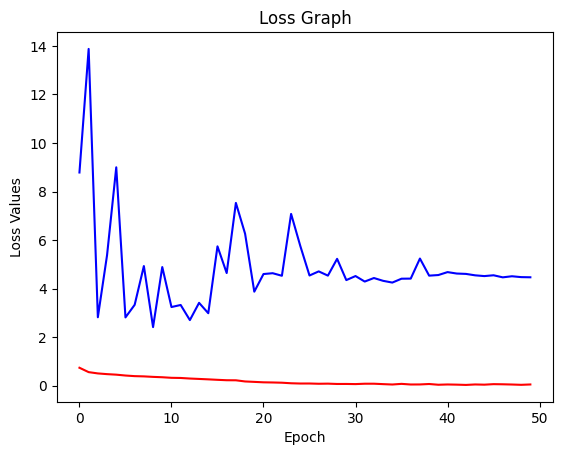

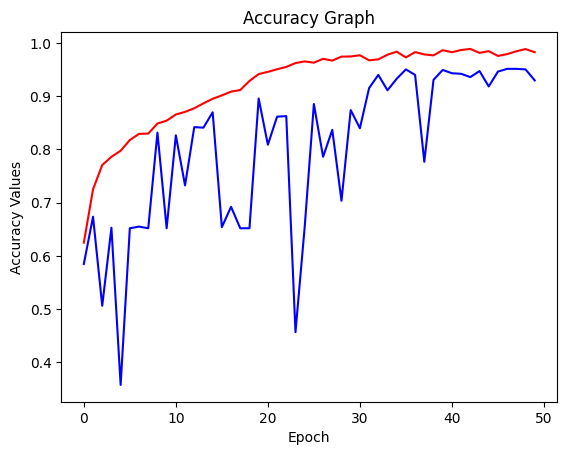

[0.9514462947845459]
[4.46701192855835]


<Figure size 640x480 with 0 Axes>

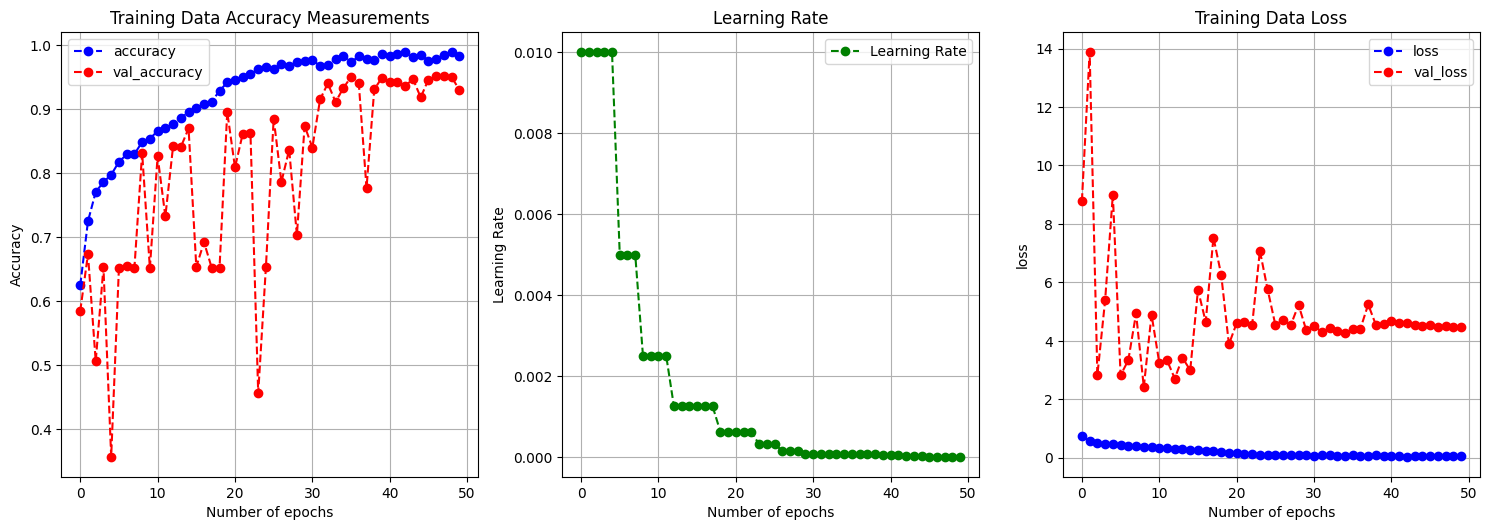

fold-3 data verileri atlandı
fold-4 data verileri atlandı
fold-5 data verileri atlandı


In [16]:
fold_var = 1

desired_fold = 2

for train_index, val_index in kf.split(x_data,y_data):
    
    if fold_var == desired_fold: 
        x_train_data = []
        y_train_data = []

        x_val_data = []
        y_val_data = []


        for i in train_index:
          x_train_data.append(x_data[i])
          y_train_data.append(y_data[i])


        for i in val_index:
          x_val_data.append(x_data[i])
          y_val_data.append(y_data[i])


        X_train = np.array(x_train_data)
        Y_train = np.array(y_train_data)

        X_val = np.array(x_val_data)
        Y_val = np.array(y_val_data)

        ################# VGG16 ##################
        pretrained_model=VGG16(input_shape = (224, 224, 3), 
                                     include_top = False, 
                                     weights = 'imagenet')

        for layer in pretrained_model.layers:
            layer.trainable = False

        for layer in pretrained_model.layers[12:]:
            layer.trainable = True


        # Define custom head for classification
        x = pretrained_model.output
        # x = Dropout(0.5)(x)
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(8192, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(4096, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2048, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        output = Dense(2, activation='softmax')(x)



        final_VGG16 = Model(inputs=pretrained_model.input, outputs=output)



        final_VGG16.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
                        loss = 'sparse_categorical_crossentropy', 
                        metrics = ['accuracy'])


        #.h5 = Hierarchical Data Format Ver. 5 file, verbose = 1, to see execution
        tensorboard= tf.keras.callbacks.TensorBoard(log_dir="logs")
        checkpoint= tf.keras.callbacks.ModelCheckpoint(f"/kaggle/working/VGG16_model_{fold_var}.keras",
                                monitor="val_accuracy", verbose=1,
                                mode="auto", save_best_only=True)

        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)


        #monitor: quantity to be monitored.     
        #factor: factor by which the learning rate will be reduced. 
        #patience: number of epochs with no improvement after which learning rate will be reduced.     
        #verbose: int. 0: quiet, 1: update messages.
        #min_delta: early stopping of epochs
        reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                       factor=0.5,
                                                       patience=3,verbose=1,
                                                       mode="auto", min_delta=0.001)


        history = final_VGG16.fit(X_train,Y_train,
                epochs=50,
                validation_data=(X_val,Y_val),
                callbacks =[tensorboard, checkpoint, reduce_lr])



        # LOAD BEST MODEL to evaluate the performance of the model
        final_VGG16.load_weights(f"/kaggle/working/VGG16_model_{fold_var}.keras")

        results = final_VGG16.evaluate(X_val,Y_val)
        results = dict(zip(final_VGG16.metrics_names,results))


        VALIDATION_ACCURACY_VGG16.append(results['compile_metrics'])
        VALIDAITON_LOSS_VGG16.append(results['loss'])


        #  Logic of all test database
        Y_pred = final_VGG16.predict(X_val)
        Y_pred = np.argmax(Y_pred, axis=1)


        #  Return pro format of classes
        target_names = ["Mild_Dementia", "Non_Demented"]

        # Confusion Matrix
        plt.figure()
        cm = confusion_matrix(Y_val, Y_pred)
        plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

        # Save confusion matrix in text
        np.savetxt(f"/kaggle/working/VGG16_cm_{fold_var}.txt",cm,fmt='%d')
        plt.savefig(f"/kaggle/working/VGG16_cm_img_{fold_var}.png")

        # Save clasification report in text
        text_file = open(f"/kaggle/working/VGG16_report_{fold_var}.txt", "w")
        n = text_file.write(classification_report(Y_val, Y_pred, target_names=target_names))
        text_file.close()

        #Comparing losses and accuraries 
        plt.figure()
        plt.plot(history.history['loss'], color='r')
        plt.plot(history.history['val_loss'], color='b')
        plt.title("Loss Graph")
        plt.xlabel("Epoch")
        plt.ylabel("Loss Values")
        plt.savefig(f"/kaggle/working/VGG16_loss_{fold_var}.png")
        plt.show()

        plt.figure()
        plt.plot(history.history['accuracy'], color='r')
        plt.plot(history.history['val_accuracy'], color='b')
        plt.title("Accuracy Graph")
        plt.ylabel("Accuracy Values")
        plt.xlabel("Epoch")
        plt.savefig(f"/kaggle/working/VGG16_accuracy_{fold_var}.png")
        plt.show()

        plt.figure()
        print(VALIDATION_ACCURACY_VGG16)
        print(VALIDAITON_LOSS_VGG16)
        
        acc_file = open(f"/kaggle/working/acc_loss_results.txt", "w")
        n = acc_file.write(str(VALIDATION_ACCURACY_VGG16))
        n2 = acc_file.write(str(VALIDAITON_LOSS_VGG16))
        acc_file.close()

        accuracy_lr_loss_plot(history)

    
    elif fold_var != desired_fold:
        print(f"fold-{fold_var} data verileri atlandı")
    else:
        print("yanlış bişeyler var hacı")
        
    fold_var += 1
    tf.keras.backend.clear_session() 